# Audio Model Creation and Quantization

This notebook demonstrates the process of training, quantizing, and evaluating audio models. The workflow includes:

1. Auto Model Generation
2. Model Training and Pruning
3. Quantization (Post-Training and Quantization-Aware)
4. Evaluation of Quantized Models
5. Analysis of Model Size vs. Accuracy

## SCC stuff

In [1]:
#when using scc and selecting jupyter modules use these in this order
#python3/3.10.12 tensorflow/2.11.0

# Imports and GPU


In [2]:
# Import basic functionality libraries
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tempfile
import shutil
import sys
import gc
import zipfile
import re
from sklearn.model_selection import train_test_split
# More specific tf import such as autotuner
from tensorflow.keras import layers
from IPython import display
import keras_tuner as kt
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, GlobalAveragePooling2D, Dense, Activation, Input, Reshape, Multiply, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, ReLU, Dropout
from tensorflow.keras import Sequential

# Libraries for model optimizations
import tensorflow_model_optimization as tfmot
#from tensorflow_model_optimization.python.core.keras.compat import keras
from keras.layers import Resizing
from tensorflow_model_optimization.quantization.keras import quantize_annotate_layer
import nbimporter
#import tf_keras as keras #this one worked for local

In [3]:
# for SCC
import tensorflow.keras as keras

## Setup tensorflow GPU support

In [4]:
use_gpu = True # set it here by hand

if use_gpu:
    # Check if GPU is available
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
    else:
        print("No GPU available")

1 Physical GPUs, 1 Logical GPUs


# Run .py preprocessing that sets up the datasets

The code below imports the datasets from serealized TFREcords, batches them, and results in the final train/test/val_spectrogram_ds datasets.

In [5]:
# Specify the path to your output directory where the .npy files are saved
output_dir = 'processed_dataset_small'  # Replace with your actual output directory

# Load the features and labels
features = np.load(os.path.join(output_dir, 'features.npy'))
labels = np.load(os.path.join(output_dir, 'labels.npy'))

print(f"Features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")

Features shape: (79961, 49, 40)
Labels shape: (79961,)


In [6]:
# Expand dimensions to add a channel dimension
features = np.expand_dims(features, -1)  # Shape becomes (num_samples, num_frames, num_mel_bins, 1)

# Split data into training + validation and test sets (80% training + validation, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels)

# Further split the training + validation set into training and validation sets (60% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"Training set shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, Labels shape: {y_val.shape}")
print(f"Test set shape: {X_test.shape}, Labels shape: {y_test.shape}")

Training set shape: (47976, 49, 40, 1), Labels shape: (47976,)
Validation set shape: (15992, 49, 40, 1), Labels shape: (15992,)
Test set shape: (15993, 49, 40, 1), Labels shape: (15993,)


In [7]:
np.unique(y_train)

array([0, 1, 2])

In [8]:
# Compute mean and standard deviation from the training data
mean = np.mean(X_train)
std = np.std(X_train)

print(f"Training data mean: {mean:.4f}, standard deviation: {std:.4f}")

# Normalize the training data
X_train_norm = (X_train - mean) / std

# Normalize the validation data
X_val_norm = (X_val - mean) / std

# Normalize the test data
X_test_norm = (X_test - mean) / std



Training data mean: -3.9069, standard deviation: 3.6885


In [9]:
def serialize_example(image, label):
    """Creates a tf.train.Example message ready to be written to a file."""
    image = tf.cast(image * 255, tf.uint8)  # Scale to [0, 255] and cast to uint8
    jpeg_image = tf.image.encode_jpeg(image)  # Encode image as JPEG
    feature = {
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[jpeg_image.numpy()])),
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def write_tfrecord(filename, images, labels):
    with tf.io.TFRecordWriter(filename) as writer:
        for image, label in zip(images, labels):
            serialized_example = serialize_example(image, label)
            writer.write(serialized_example)
    print(f"TFRecord file created: {filename}")

# Step 3: Write each dataset to a separate TFRecord file
write_tfrecord('train_spec_ds.tfrecord', X_train_norm, y_train)
write_tfrecord('val_spec_ds.tfrecord', X_val_norm, y_val)
write_tfrecord('test_spec_ds.tfrecord', X_test_norm, y_test)

TFRecord file created: train_spec_ds.tfrecord
TFRecord file created: val_spec_ds.tfrecord
TFRecord file created: test_spec_ds.tfrecord


In [10]:
# Function to parse a single serialized example from TFRecord
def _parse_function(proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),  # Image is stored as a string
        'label': tf.io.FixedLenFeature([], tf.int64),   # Label is an int64
    }
    
    # Parse the input `tf.train.Example` proto using the feature description
    parsed_example = tf.io.parse_single_example(proto, feature_description)
    
    # Decode the JPEG-encoded image back into a float32 tensor
    image = tf.io.decode_jpeg(parsed_example['image'], channels=1)  # Grayscale
    image = tf.image.convert_image_dtype(image, tf.float32)  # Convert to [0, 1] range
    
    # Reshape the image to its original shape (e.g., [49, 40, 1])
    image = tf.reshape(image, [49, 40, 1])
    
    # Get the label
    label = parsed_example['label']
    
    return image, label

In [11]:
# Function to load the dataset from a TFRecord file
def load_dataset(tfrecord_file, batch_size=64):
    # Load the TFRecord file
    raw_dataset = tf.data.TFRecordDataset(tfrecord_file)
    
    # Parse the serialized data using the _parse_function
    parsed_dataset = raw_dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Batch and shuffle the dataset (optional, depending on your needs) buffer_size is not size of batch its size of buffer
    parsed_dataset = parsed_dataset.shuffle(buffer_size=1000).batch(batch_size)
    parsed_dataset = parsed_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return parsed_dataset

In [12]:
# Load the train, test, and validation datasets from TFRecord files
train_spectrogram_ds = load_dataset('train_spec_ds.tfrecord')
test_spectrogram_ds = load_dataset('test_spec_ds.tfrecord')
val_spectrogram_ds = load_dataset('val_spec_ds.tfrecord')

In [13]:
new_size = len(list(train_spectrogram_ds))
print(f"New dataset size: {new_size}")

# Get input shape and number of classes
for spectrograms, labels in train_spectrogram_ds.take(1):
    input_shape = spectrograms.shape
    print('Input shape:', input_shape)

New dataset size: 750
Input shape: (64, 49, 40, 1)


In [14]:
new_size = len(list(test_spectrogram_ds))
print(f"New dataset size: {new_size}")

New dataset size: 250


# Keras Autotuner

The below functions uses keras autotuner to generate models of a general shape defined in the AutoTuner.build_model  
and saves the models if their sizes and accuracies meet some thresholds.
The training output is truncated so that on the SCC the training can be faster.  
The code works on the SCC but for whatever reason I keep running into a CPU memory overflow even tho I  
specifically delete the history of models and train in batches. We can work to fix this but I already generated   
about a hundred models so it is not a priority.

In [15]:
from keras_tuner import errors

In [16]:
import audio_models
import logging
from contextlib import contextmanager

no_logs = False # set to false to see printouts of models during training

#class CustomLogger(logging.Logger):
#    def __init__(self, name, level=logging.ERROR):  # Only log errors
#        super().__init__(name, level)
        
# Suppress Keras Tuner logger
logging.getLogger("keras_tuner").setLevel(logging.CRITICAL)

if no_logs:
    # Suppress TensorFlow and Keras Tuner logs
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logs
    tf.get_logger().setLevel(logging.ERROR)  # Suppress TensorFlow's Python warnings
    logging.getLogger("keras_tuner").setLevel(logging.CRITICAL)  # Suppress Keras Tuner logs


@contextmanager
def suppress_output():
    """
    Suppress all output to stdout and stderr.
    """
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

def run_with_iteration_display(autotuner, train_data, val_data, num_epochs, max_trials):
    """
    Run the tuner with suppressed output, but display the current iteration number.
    """
    for current_trial in range(1, max_trials + 1):
        # Print the current trial number outside the suppress_output context
        print(f"\rTraining model {current_trial} out of {max_trials}...", end="", flush=True)

        # Suppress all other outputs during the trial
        with suppress_output():
            try:
                autotuner.run_tuner(train_data, val_data, num_epochs)
            except RuntimeError as e:
                # Handle errors gracefully without terminating the loop
                print(f"\nError encountered during trial {current_trial}: {str(e)}")
                continue
                
    # Access and display the number of saved models
    saved_model_count = autotuner.tuner.saved_model_count
    print(f"\nTraining complete. Saved {saved_model_count} models that fit the criteria.")

In [17]:
class CustomRandomSearch(kt.RandomSearch):
    def __init__(self, *args, save_dir=None, parameter_threshold=None, accuracy_threshold=None, oracle = None, **kwargs):
        super().__init__(*args, **kwargs)
        self.save_dir = save_dir
        self.parameter_threshold = parameter_threshold
        self.accuracy_threshold = accuracy_threshold
        os.makedirs(self.save_dir, exist_ok=True)
        self.saved_model_count = 0  # Counter for saved models

    def run_trial(self, trial, *fit_args, **fit_kwargs):
        current_trial = int(trial.trial_id) + 1
        total_trials = self.oracle.max_trials
        print(f"\rTraining model {current_trial} of {total_trials}", end="")  

        model = self.hypermodel.build(trial.hyperparameters)
        if hasattr(model, 'is_invalid') and model.is_invalid:
            # For invalid models, return a fixed low score without training
            self.oracle.update_trial(
                trial.trial_id, {'val_accuracy': float('-inf')}
            )
            return

        # Add early stopping callback to fit_kwargs
        callbacks = fit_kwargs.get('callbacks', [])
        callbacks.extend([
            tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                min_delta=0.01,
                patience=3,
                restore_best_weights=True,
                verbose=0 #1
            )
        ])
        fit_kwargs['callbacks'] = callbacks

        # Train the model
        history = model.fit(*fit_args, **fit_kwargs, verbose = 0)

        # Extract the best validation accuracy
        val_accuracy = max(history.history.get('val_accuracy', [0]))
        num_params = model.count_params()

        # Save the model if thresholds are met
        if val_accuracy > self.accuracy_threshold and num_params < self.parameter_threshold:
            model_save_path = os.path.join(
                self.save_dir,
                f"model_trial_{trial.trial_id}_acc_{int(val_accuracy * 100)}_params_{num_params}.keras"
            )
            model.save(model_save_path)
            print(f"Saved model from trial {trial.trial_id} with accuracy: {val_accuracy:.2f} and params: {num_params}")
            self.saved_model_count += 1
            del model
            gc.collect()

        # Report the metric to the tuner
        self.oracle.update_trial(
            trial.trial_id, {'val_accuracy': val_accuracy}
        )

In [18]:
class AutoTuner:
    def __init__(self, tuner_dir, save_dir, parameter_threshold, accuracy_threshold, max_trials=10, executions_per_trial=1):
        self.tuner_dir = tuner_dir
        self.save_dir = save_dir
        self.parameter_threshold = parameter_threshold
        self.accuracy_threshold = accuracy_threshold
        self.max_trials = max_trials
        self.executions_per_trial = executions_per_trial

        # Clean up the tuner directory if it already exists
        if os.path.exists(self.tuner_dir):
            shutil.rmtree(self.tuner_dir)
            
        # Create the oracle with a custom limit for consecutive failures
        oracle = kt.oracles.RandomSearchOracle(
            objective=kt.Objective("val_accuracy", direction="max"),
            max_consecutive_failed_trials=10  # Adjust as needed
        )

        # Initialize the tuner
        self.tuner = CustomRandomSearch(
            self.build_model,
            oracle=oracle,
            max_trials=self.max_trials,
            executions_per_trial=self.executions_per_trial,
            directory=self.tuner_dir,
            overwrite=True,  # Overwrite results to free memory
            project_name='model_tuning',
            save_dir=self.save_dir,
            parameter_threshold=self.parameter_threshold,
            accuracy_threshold=self.accuracy_threshold,
        )

    def build_model(self, hp):
        """
        Build model with validation checks that allow skipping invalid configurations.
        """
        model = tf.keras.Sequential()
        input_shape = (49, 40, 1)

        # Input layer
        model.add(layers.Input(shape=input_shape))
        
        current_height, current_width = input_shape[0], input_shape[1]
        is_valid = True

        # Convolutional layers with tunable filters, kernel size, and stride
        for i in range(hp.Int('num_conv_layers', 1, 3)):
            kernel_size = hp.Choice(f'kernel_size_{i}', values=[6, 8, 10, 12])
            stride = hp.Choice(f'stride_{i}', values=[2, 4, 8, 10, 12])
            
            # Calculate new spatial dimensions
            new_height = (current_height - kernel_size) // stride + 1
            new_width = (current_width - kernel_size) // stride + 1
            
            # Check if dimensions are valid
            if new_height <= 0 or new_width <= 0:
                print(f"Invalid configuration at layer {i}: kernel_size={kernel_size}, stride={stride}, input_shape=({current_height}, {current_width})")
                is_valid = False
                break

            # Add convolutional layer if valid
            model.add(layers.Conv2D(
                filters=hp.Int(f'filters_{i}', min_value=6, max_value=12, step=2),
                kernel_size=kernel_size,
                strides=stride,
                activation='relu'
            ))
            model.add(layers.Dropout(rate=hp.Choice('dropout_rate', values=[0.1, 0.2, 0.3])))

            # Update current dimensions
            current_height, current_width = new_height, new_width

        # If dimensions are invalid, return an invalid model
        if not is_valid:
            model.is_invalid = True
            return model

        # Add dropout here or at the end of every conv iteration
        #model.add(layers.Dropout(rate=hp.Choice('dropout_rate', values=[0.1, 0.2, 0.3])))

        # Flatten layer
        model.add(layers.Flatten())

        # Output layer
        model.add(layers.Dense(3, activation='softmax'))

        model_params = model.count_params()
        if model_params > self.parameter_threshold:
            print(f"Model exceeds parameter limit: {model_params} params")
            model.is_invalid = True
        else:
            # Compile the model
            model.compile(
                optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3])),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
            )
            model.is_invalid = False

        return model


    def run_tuner(self, train_data, val_data, num_epochs):
        """
        Run the tuner to search for the best model.
        """
        self.tuner.search(train_data, validation_data=val_data, epochs=num_epochs)
        print(f"\nTraining complete. Saved {self.tuner.saved_model_count} models that fit the criteria.")

In [19]:
# you can remove the wrapper run_with_iteration_display and just call the autotuner for full training output
parameter_threshold = 20000 # Model sizes will be below this threshold
accuracy_threshold = 0.93 # Models must have validation accuracy above this threshold
num_epochs = 20
max_trials = 30
tuner_dir = 'autotuner_dir'
save_dir = "saved_models"
batch_size = 10

# Instantiate and run the AutoTuner
for batch in range(0, max_trials, batch_size):
    print(f"Running trials {batch + 1} to {batch + batch_size}")
    autotuner = AutoTuner(tuner_dir, save_dir, parameter_threshold, accuracy_threshold, max_trials=batch_size)
    run_with_iteration_display(autotuner, train_spectrogram_ds, val_spectrogram_ds, num_epochs, batch_size)
    del autotuner
    
# If you dont want to train in batches you can use this
#autotuner = AutoTuner(tuner_dir, save_dir, parameter_threshold, accuracy_threshold, max_trials)
#run_with_iteration_display(autotuner, train_spectrogram_ds, val_spectrogram_ds, num_epochs, max_trials)

Training model 10 out of 10...
Training complete. Saved 2 models that fit the criteria.


# Weight initializations?

https://arxiv.org/pdf/2402.18153

# Novel CNN resnet based models?

https://arxiv.org/pdf/2406.02652

# Train Base Models

In [20]:
def plot_training_history(history, model_index):
    """Plots training and validation accuracy and loss."""
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model {model_index} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model {model_index} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [21]:
def filter_keras_models(directory, min_accuracy, max_params):
    """
    Filters .keras models in a directory based on minimum accuracy and maximum parameters.

    Args:
        directory (str): Path to the directory containing .keras model files.
        min_accuracy (float): Minimum accuracy threshold (e.g., 71 for 71%).
        max_params (int): Maximum parameter count threshold.

    Returns:
        list: A list of file paths for models that meet the criteria.
    """
    usable_models = []
    model_pattern = r"model_trial_\d+_acc_(\d+)_params_(\d+)\.keras"

    for filename in os.listdir(directory):
        if filename.endswith(".keras"):
            match = re.match(model_pattern, filename)
            if match:
                accuracy = int(match.group(1))  # Extract accuracy
                params = int(match.group(2))   # Extract parameter count
                
                # Check if the model fits the requirements
                if accuracy >= min_accuracy and params <= max_params:
                    usable_models.append(os.path.join(directory, filename))

    return usable_models

In [22]:
# Define directory and thresholds
directory = "saved_models"
min_accuracy = 93  # Minimum accuracy 
max_params = 10000  # Maximum parameter count 

# Get usable models
usable_models = filter_keras_models(directory, min_accuracy, max_params)

print("Usable Models:")
for model in usable_models:
    print(model)

# After some searching we are going to use a model above 90% accuracy and below 4000 parameters
# saved_models/model_trial_00_acc_92_params_3798.keras
# saved_models/model_trial_00_acc_90_params_3288.keras


# and a model with more than 93% accuracy and below 10000 parameters
# saved_models/model_trial_00_acc_95_params_5190.keras
# saved_models/model_trial_00_acc_94_params_4032.keras


#for SCC
loaded_model_file_paths = ["saved_models/model_trial_00_acc_92_params_3798.keras", "saved_models/model_trial_00_acc_90_params_3288.keras",
                          "saved_models/model_trial_00_acc_94_params_4032.keras", "saved_models/model_trial_00_acc_95_params_5190.keras"]



Usable Models:
saved_models/model_trial_00_acc_93_params_2904.keras
saved_models/model_trial_00_acc_94_params_4032.keras
saved_models/model_trial_00_acc_94_params_7914.keras
saved_models/model_trial_00_acc_95_params_5190.keras
saved_models/model_trial_00_acc_93_params_3072.keras
saved_models/model_trial_00_acc_95_params_3033.keras
saved_models/model_trial_02_acc_93_params_2130.keras
saved_models/model_trial_01_acc_94_params_5604.keras


In [23]:
def train_or_evaluate_models(model_file_paths, root_dir, train_ds, val_ds, test_ds, epochs=30, retrain=False):
    """
    Retrains or evaluates models from .keras files.

    Args:
        model_file_paths (list): List of relative paths to .keras model files.
        root_dir (str): Root directory where the models are stored.
        train_ds: Training dataset.
        val_ds: Validation dataset.
        test_ds: Test dataset for evaluation.
        epochs (int): Number of epochs for retraining.
        retrain (bool): If True, retrains the model; otherwise, evaluates it as is.

    Returns:
        results (dict): Dictionary containing training histories (if retrained) or evaluation scores.
    """
    models = []

    for i, model_path in enumerate(model_file_paths):
        # Construct the absolute path
        full_model_path = os.path.join(root_dir, model_path)
        print(f"\nProcessing Model {i}: {full_model_path}")

        # Debug: Ensure file path correctness
        if not os.path.exists(full_model_path):
            print(f"Error: File does not exist at {full_model_path}")
            continue

        # Load the pretrained model
        try:
            model = tf.keras.models.load_model(full_model_path)
        except ValueError as e:
            print(f"Error loading model from {full_model_path}: {e}")
            continue

        if retrain:
            # Compile the model before retraining
            model.compile(
                optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy']
            )
            model.summary()

            # Retrain the model
            history = model.fit(
                train_ds,
                validation_data=val_ds,
                epochs=epochs,
                callbacks=[keras.callbacks.EarlyStopping(verbose=1, patience=2, min_delta=0.01)],
                verbose=1
            )
            
            # Plot training history
            plot_training_history(history, i)
        else:
            # Evaluate the model without retraining
            eval_score = model.evaluate(test_ds, verbose=1)
            print(f"Evaluation Score for Model {i}: {eval_score}")

        models.append(model)


    return models

In [24]:
root_directory = r"/projectnb/cs640grp/projects/tinyml" # for SCC
# root_directory = "C:\\Users\\adamk\\Downloads\\micro_speech_model_making\\notebooks\\" # for local

new_models = train_or_evaluate_models(
    model_file_paths=loaded_model_file_paths,
    root_dir=root_directory,
    train_ds=train_spectrogram_ds,
    val_ds=val_spectrogram_ds,
    test_ds=test_spectrogram_ds,
    epochs=10,
    retrain=False  # Retrain the models
)


Processing Model 0: /projectnb/cs640grp/projects/tinyml/saved_models/model_trial_00_acc_92_params_3798.keras
250/250 [==============================] - 0s 991us/step - loss: 3.2124 - accuracy: 0.1591
Evaluation Score for Model 0: [3.2123868465423584, 0.15913212299346924]

Processing Model 1: /projectnb/cs640grp/projects/tinyml/saved_models/model_trial_00_acc_90_params_3288.keras
250/250 [==============================] - 0s 976us/step - loss: 2.6872 - accuracy: 0.1970
Evaluation Score for Model 1: [2.6872241497039795, 0.1969611644744873]

Processing Model 2: /projectnb/cs640grp/projects/tinyml/saved_models/model_trial_00_acc_94_params_4032.keras
250/250 [==============================] - 0s 1ms/step - loss: 0.1411 - accuracy: 0.9404
Evaluation Score for Model 2: [0.14114736020565033, 0.9404114484786987]

Processing Model 3: /projectnb/cs640grp/projects/tinyml/saved_models/model_trial_00_acc_95_params_5190.keras
250/250 [==============================] - 0s 983us/step - loss: 0.1274 - 


Training Model 0
Model: "tiny_embed_conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 25, 20, 8)         648       
                                                                 
 relu1 (ReLU)                (None, 25, 20, 8)         0         
                                                                 
 dropout1 (Dropout)          (None, 25, 20, 8)         0         
                                                                 
 conv2 (Conv2D)              (None, 4, 3, 8)           5128      
                                                                 
 relu2 (ReLU)                (None, 4, 3, 8)           0         
                                                                 
 dropout2 (Dropout)          (None, 4, 3, 8)           0         
                                                                 
 flatten (Flatten)         

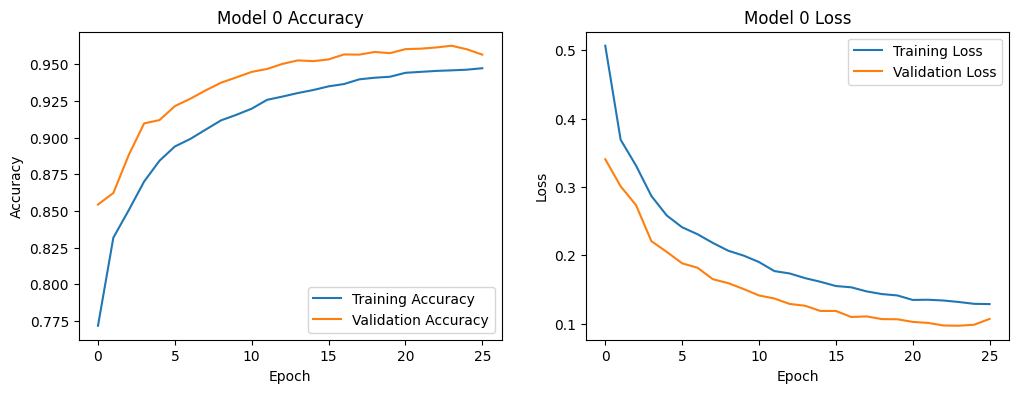

In [25]:
models = []
histories = []
sequential_models = True


for i, create_model in enumerate([audio_models.create_tiny_embed_conv_model_small]):
    print(f'\nTraining Model {i}')
    input_shape = (49, 40, 1)
    model = create_model(input_shape)
    
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    model.summary()


    history = model.fit(
        train_spectrogram_ds,
        validation_data = val_spectrogram_ds,
        epochs=40,  # You can adjust the number of epochs
        callbacks=keras.callbacks.EarlyStopping(verbose=1, patience=3, min_delta=0.001),
        verbose = 1
    )
    models.append(model)
    histories.append(history)
    
    plot_training_history(history, i)


## Compile and test models

In [26]:
final_models = new_models + models

In [27]:


# Function to reload any serialized models (from bytes) if necessary
def load_if_serialized(model):
    if isinstance(model, bytes):
        # Assuming the model was saved as bytes, use `tf.keras.models.model_from_json` or similar
        raise TypeError("Model is in a serialized bytes format. Please load it as a Keras model before passing.")
    return model

def get_gzipped_model_size(model):
    # Save the model to a temporary file in .keras format
    with tempfile.NamedTemporaryFile(suffix='.keras', delete=False) as temp_file:
        model.save(temp_file.name)
        model_filename = temp_file.name

    # Compress the model file to calculate its gzipped size
    with tempfile.NamedTemporaryFile(suffix='.zip', delete=False) as temp_zip:
        zipped_file = temp_zip.name
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(model_filename, arcname='model.keras')

    # Get the size of the gzipped model file in kilobytes
    gzipped_size = os.path.getsize(zipped_file) / 1000  # Convert bytes to KB

    # Clean up temporary files
    os.remove(model_filename)
    os.remove(zipped_file)

    return gzipped_size

def plot_size_v_accuracy(models, X_test_norm):
    # Lists to store the results
    accuracies = []
    model_sizes = []
    model_names = []

    # Evaluate each model and store the results
    for i, model in enumerate(models, start=1):
        try:
            # Load model if it's in serialized bytes format
            model = load_if_serialized(model)

            # Check if model is a Keras model instance
            #if not isinstance(model, tf.keras.Model):
            #    raise TypeError(f"Model {i} is not a Keras model instance.")

            # Check if the model is compiled by looking for an optimizer
            if model.optimizer is None:
                model.compile(
                    optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy']
                )
            
            # Evaluate the model
            test_loss, test_acc = model.evaluate(X_test_norm, verbose=0)

            # Calculate the gzipped model size
            gzipped_size = get_gzipped_model_size(model)

            # Print the details
            print(f"Model {i} ({model.name}):")
            print(f"  Gzipped Model Size: {gzipped_size:.2f} KB")
            print(f"  Test Accuracy: {test_acc:.4f}")
            
            # Store the accuracy and model size
            accuracies.append(test_acc)
            model_sizes.append(gzipped_size)
            model_names.append(model.name)

        except Exception as e:
            print(f"An error occurred with Model {i}: {e}")

    # Plotting accuracy vs. gzipped model size
    plt.figure(figsize=(10, 6))
    plt.plot(model_sizes, accuracies, marker='o', linestyle='', color='b')

    for i, model_name in enumerate(model_names):
        plt.text(model_sizes[i], accuracies[i], model_name, fontsize=9, ha='right')

    # Add labels and title
    plt.xlabel('Gzipped Model Size (KB)')
    plt.ylabel('Test Accuracy')
    plt.title('Model Accuracy vs. Gzipped Model Size')
    plt.grid(True)
    plt.show()

Model 1 (sequential_547):
  Gzipped Model Size: 46.87 KB
  Test Accuracy: 0.1591
Model 2 (sequential_768):
  Gzipped Model Size: 41.97 KB
  Test Accuracy: 0.1970
Model 3 (sequential_14):
  Gzipped Model Size: 49.16 KB
  Test Accuracy: 0.9404
Model 4 (sequential_1):
  Gzipped Model Size: 62.82 KB
  Test Accuracy: 0.9452
Model 5 (tiny_embed_conv_model):
  Gzipped Model Size: 72.20 KB
  Test Accuracy: 0.9593


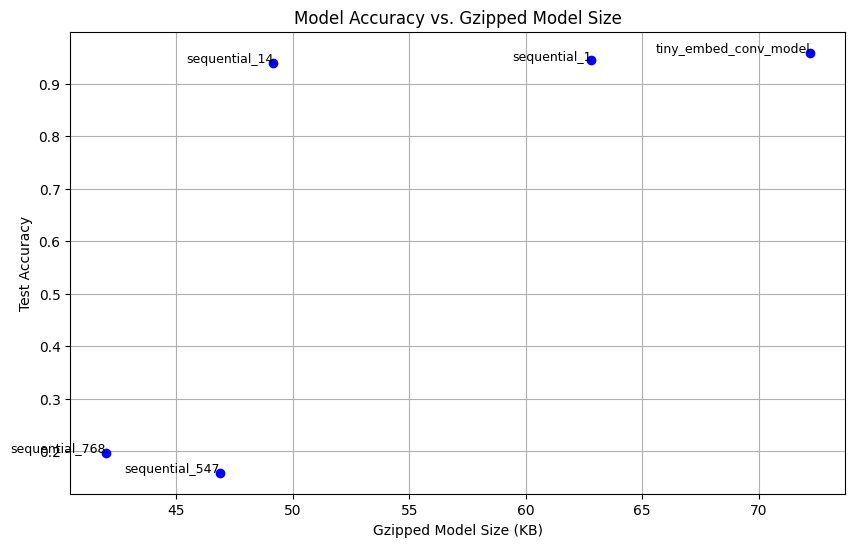

In [28]:
plot_size_v_accuracy(final_models, test_spectrogram_ds)

# Shrinking the model

[deployment on the edge](https://ai.google.dev/edge/litert)

[general model optimizations](https://www.tensorflow.org/model_optimization/guide)

We will start off with pruning

we will aslo try quantization aware training to quantize the model
and we will also try different post-training quantizations

we can also try weight clustering

and finalyl we will try a single workflow with a combination of the previous methods
[collaborative optimizations](https://www.tensorflow.org/model_optimization/guide/combine/collaborative_optimization)


https://blog.tensorflow.org/2024/04/faster-dynamically-quantized-inference-with-xnnpack.html



# Pruning (pruning does not work with the generated models, ill have to fix that)

In [29]:
### Helper functions for pruning

def ds_to_numpy(dataset):
    """Converts a tf.data.Dataset to numpy arrays for data and labels."""
    data = []
    labels = []
    
    for features, label in dataset:
        data.append(features)
        labels.append(label)

    data = tf.concat(data, axis=0)
    labels = tf.concat(labels, axis=0)
    return data, labels

def print_model_weights_sparsity(model):
    """Prints the sparsity (percentage of zeros) for each layer's weights in the model."""
    for layer in model.layers:
        if isinstance(layer, keras.layers.Wrapper):  # For pruned layers wrapped in the pruning wrapper
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            weight_np = weight.numpy()
            weight_size = weight_np.size
            zero_num = np.count_nonzero(weight_np == 0)
            print(f"{weight.name}: {zero_num / weight_size:.2%} sparsity ({zero_num}/{weight_size})")
            
def sequential_to_functional(sequential_model):
    # Extract the layers from the Sequential model
    inputs = Input(shape=sequential_model.input_shape[1:])
    x = inputs

    # Apply each layer from the Sequential model in sequence
    for layer in sequential_model.layers:
        x = layer(x)
    
    # Create a new functional model
    functional_model = Model(inputs=inputs, outputs=x)
    
    # Copy weights from the Sequential model
    functional_model.set_weights(sequential_model.get_weights())

    print(functional_model)
    
    return functional_model

In [30]:
def prune_model(model, train_spectrogram_ds, test_spectrogram_ds, qat=False):
    """Prunes the given model with optional quantization-aware training (QAT)."""
    # Ensure model is compatible with pruning by converting it to functional if needed
    #model = sequential_to_functional(model)
    
    # Convert datasets to numpy arrays
    train_data, train_labels = ds_to_numpy(train_spectrogram_ds)
    test_data, test_labels = ds_to_numpy(test_spectrogram_ds)

    # Define pruning parameters
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=0, frequency=100)
    }
    
    # Define pruning callbacks
    callbacks = [tfmot.sparsity.keras.UpdatePruningStep()]

    # Apply pruning
    if qat:
        # Quantization-aware training with pruning
        quant_aware_annotate_model = tfmot.quantization.keras.quantize_annotate_model(model)
        pruned_model = tfmot.quantization.keras.quantize_apply(
            quant_aware_annotate_model,
            tfmot.experimental.combine.Default8BitPrunePreserveQuantizeScheme()
        )
    else:
        # Standard pruning
        pruned_model = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

    # Compile the pruned model with a smaller learning rate for fine-tuning
    pruned_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    
    # Display model summary
    pruned_model.summary()

    # Fine-tune the pruned model
    pruned_model.fit(
        train_data,
        train_labels,
        epochs=3,
        validation_split=0.1,
        callbacks=callbacks
    )

    # Strip pruning wrappers for final deployment
    stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

    # Check sparsity levels
    print_model_weights_sparsity(stripped_pruned_model)

    # Evaluate the pruned model on test data
    _, pruned_model_accuracy = pruned_model.evaluate(test_data, test_labels, verbose=0)
    print("Pruned test accuracy:", pruned_model_accuracy)

    return stripped_pruned_model

In [31]:
basic_pruned_models = []

for model in final_models:
    pruned_model = prune_model(model, train_spectrogram_ds, test_spectrogram_ds, qat=False)
    basic_pruned_models.append(pruned_model)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "sequential_547"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d_  (None, 22, 18, 6)        440       
 823 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_dropout  (None, 22, 18, 6)        1         
 _823 (PruneLowMagnitude)                                        
                                                                 
 prune_low_magnitude_conv2d_  (None, 9, 7, 6)          2600      
 824 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_dropout  (None, 9, 7, 6)    

/share/pkg.7/tensorflow/2.11.0/install/lib/SCC/../python3.10/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1350/1350 [==============================] - 4s 2ms/step - loss: 2.1669 - accuracy: 0.1927 - val_loss: 1.6911 - val_accuracy: 0.1588
Epoch 2/3
1350/1350 [==============================] - 2s 2ms/step - loss: 1.5978 - accuracy: 0.2024 - val_loss: 1.3755 - val_accuracy: 0.1724
Epoch 3/3
1350/1350 [==============================] - 2s 2ms/step - loss: 1.3101 - accuracy: 0.2266 - val_loss: 1.2198 - val_accuracy: 0.1924
conv2d_823/kernel:0: 50.00% sparsity (108/216)
conv2d_823/bias:0: 0.00% sparsity (0/6)
conv2d_824/kernel:0: 50.00% sparsity (648/1296)
conv2d_824/bias:0: 0.00% sparsity (0/6)
dense_316/kernel:0: 50.00% sparsity (1134/2268)
dense_316/bias:0: 0.00% sparsity (0/6)
Pruned test accuracy: 0.19008316099643707
Model: "sequential_768"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d_  (None, 20, 16, 6)        1208      
 1083 (PruneLowMagnitude)                              

1350/1350 [==============================] - 3s 2ms/step - loss: 0.2389 - accuracy: 0.9207 - val_loss: 0.1560 - val_accuracy: 0.9491
conv2d_1/kernel:0: 50.00% sparsity (600/1200)
conv2d_1/bias:0: 0.00% sparsity (0/12)
conv2d_2/kernel:0: 50.00% sparsity (1296/2592)
conv2d_2/bias:0: 0.00% sparsity (0/6)
conv2d_3/kernel:0: 50.00% sparsity (648/1296)
conv2d_3/bias:0: 0.00% sparsity (0/6)
dense_1/kernel:0: 50.00% sparsity (36/72)
dense_1/bias:0: 0.00% sparsity (0/6)
Pruned test accuracy: 0.9435377717018127
Model: "tiny_embed_conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv1 (  (None, 25, 20, 8)        1290      
 PruneLowMagnitude)                                              
                                                                 
 prune_low_magnitude_relu1 (  (None, 25, 20, 8)        1         
 PruneLowMagnitude)                                              


Model 1 (sequential_547):
  Gzipped Model Size: 11.06 KB
  Test Accuracy: 0.1901
Model 2 (sequential_768):
  Gzipped Model Size: 10.49 KB
  Test Accuracy: 0.2629
Model 3 (sequential_14):
  Gzipped Model Size: 11.96 KB
  Test Accuracy: 0.9380
Model 4 (sequential_1):
  Gzipped Model Size: 14.92 KB
  Test Accuracy: 0.9435
Model 5 (tiny_embed_conv_model):
  Gzipped Model Size: 16.75 KB
  Test Accuracy: 0.9491


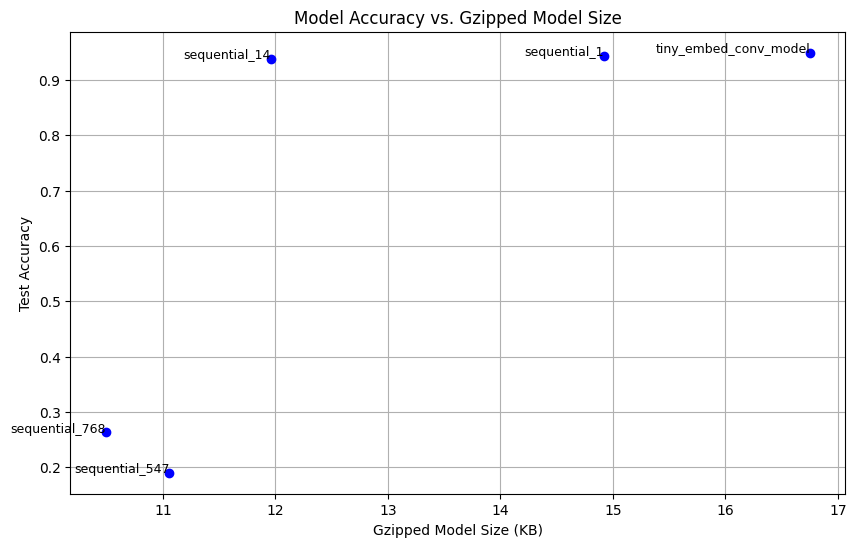

In [32]:
plot_size_v_accuracy(basic_pruned_models, test_spectrogram_ds)

## Pruning preserving quantization aware training (PQAT)
https://www.tensorflow.org/model_optimization/guide/combine/pqat_example

## Sparsity and cluster preserving quantization aware training
https://www.tensorflow.org/model_optimization/guide/combine/pcqat_example

# Quantize models

https://www.tensorflow.org/model_optimization/guide

https://blog.tensorflow.org/2024/04/faster-dynamically-quantized-inference-with-xnnpack.html


we can also add some weight clustering?

## quantization aware training quantized models with or without pruning
https://www.tensorflow.org/model_optimization/guide/quantization/training_example

https://www.tensorflow.org/model_optimization/guide/quantization/training_comprehensive_guide#quantize_some_layers

In [33]:
#import tensorflow_model_optimization as tfmot

#quantization aware training with int8 weights and uint8 activations.
def qat(model, pruned = False, save = False):
  # translate model to be quantization aware
  quantize_model = tfmot.quantization.keras.quantize_model

  # Use `quantize_scope` to register the custom NoOpQuantizeConfig object
  with tfmot.quantization.keras.quantize_scope({'NoOpQuantizeConfig': audio_models.NoOpQuantizeConfig}):
      # Annotate the model for QAT
      quant_aware_annotated_model = tfmot.quantization.keras.quantize_annotate_model(model)
      
      # Apply QAT
      if pruned:
        q_aware_model = tfmot.quantization.keras.quantize_apply(quant_aware_annotated_model, 
                                                                tfmot.experimental.combine.Default8BitPrunePreserveQuantizeScheme())
      else:
        q_aware_model = tfmot.quantization.keras.quantize_apply(quant_aware_annotated_model)



  # Debug: Print model type and structure
  print(f"Model type: {type(model)}")
  print(f"Is Sequential: {isinstance(model, tf.keras.Sequential)}")
  print(f"Is Functional: {hasattr(model, '_is_graph_network') and model._is_graph_network}")
  model.summary()

  # Check if the model is Sequential or Functional
  if not isinstance(model, tf.keras.Sequential) and not (hasattr(model, '_is_graph_network') and model._is_graph_network):
    raise ValueError('`model` must be a Keras Sequential or Functional model.')

  #q_aware_model = quantize_model(quant_aware_model)

  q_aware_model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
  
  q_aware_model.summary()

  num_batches = tf.data.experimental.cardinality(train_spectrogram_ds).numpy()
  print(f"Number of batches in the training dataset: {num_batches}")

  # finetune quant aware model with quant aware training
  q_aware_model.fit(train_spectrogram_ds.take(num_batches // 4), batch_size = 100, epochs=1, validation_data=val_spectrogram_ds)



  _, baseline_model_accuracy = model.evaluate(test_spectrogram_ds, verbose=0)

  _, q_aware_model_accuracy = q_aware_model.evaluate(test_spectrogram_ds, verbose=0)

  print('Baseline test accuracy:', baseline_model_accuracy)
  print('Quant test accuracy:', q_aware_model_accuracy)

  if save:
    # now we haveint8 weights and uint8 activations.
    # Convert the model to TFLite
    converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    quantized_tflite_model = converter.convert()
    if pruned:
      model_filename = f'pruned_qat_{model.name}.tflite'
    else:
      model_filename = f'qat_{model.name}.tflite'
    # Save the quantized model
    with open(model_filename, 'wb') as f:
      f.write(quantized_tflite_model)

    return model_filename
  
  return q_aware_model

In [34]:
# Evaluate the TFLite quantized model
def evaluate_tflite_model(interpreter, dataset):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    total_samples = 0
    correct_predictions = 0

    for spectrograms, labels in dataset:
        input_data = spectrograms.numpy().astype('float32')
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        predictions = interpreter.get_tensor(output_details[0]['index'])
        predicted_labels = tf.argmax(predictions, axis=1)
        correct_predictions += tf.reduce_sum(tf.cast(predicted_labels == labels, tf.int32)).numpy()
        total_samples += labels.shape[0]

    accuracy = correct_predictions / total_samples
    return accuracy

In [35]:
quantized_qat_models = []
pruning_quantized_qat_models = []


# Do qat with non-pruned models
for model in final_models:
    qat_tflite_model = qat(model, pruned = False, save=True)
    quantized_qat_models.append(qat_tflite_model)

# Do qat with pruned models
for model in basic_pruned_models:
    pruned_qat_tflite_model = qat(model, pruned = True, save = True)
    pruning_quantized_qat_models.append(pruned_qat_tflite_model)



'''
# Evaluate the TFLite quantized model
interpreter = tf.lite.Interpreter(model_content=qat_models[0])
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


#quantized_model_accuracy = evaluate_tflite_model(interpreter, test_spectrogram_ds)
#print('Quantized TFLite model test accuracy:', quantized_model_accuracy)

'''

Model type: <class 'keras.engine.sequential.Sequential'>
Is Sequential: True
Is Functional: True
Model: "sequential_547"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_823 (Conv2D)         (None, 22, 18, 6)         222       
                                                                 
 dropout_823 (Dropout)       (None, 22, 18, 6)         0         
                                                                 
 conv2d_824 (Conv2D)         (None, 9, 7, 6)           1302      
                                                                 
 dropout_824 (Dropout)       (None, 9, 7, 6)           0         
                                                                 
 flatten_316 (Flatten)       (None, 378)               0         
                                                                 
 dense_316 (Dense)           (None, 6)                 2274      
                     

INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmplrf9zx_a/assets


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmplrf9zx_a/assets
/share/pkg.7/tensorflow/2.11.0/install/lib/SCC/../python3.10/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Model type: <class 'keras.engine.sequential.Sequential'>
Is Sequential: True
Is Functional: True
Model: "sequential_768"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1083 (Conv2D)        (None, 20, 16, 6)         606       
                                                                 
 dropout_1083 (Dropout)      (None, 20, 16, 6)         0         
                                                                 
 conv2d_1084 (Conv2D)        (None, 8, 6, 6)           1302      
                                                                 
 dropout_1084 (Dropout)      (None, 8, 6, 6)           0         
                                                                 
 conv2d_1085 (Conv2D)        (None, 2, 1, 6)           1302      
                                                                 
 dropout_1085 (Dropout)      (None, 2, 1, 6)           0         
                     

/share/pkg.7/tensorflow/2.11.0/install/lib/SCC/../python3.10/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


750/750 [==============================] - 3s 3ms/step - loss: 0.5362 - accuracy: 0.7187 - val_loss: 0.2881 - val_accuracy: 0.8839
Baseline test accuracy: 0.2629275321960449
Quant test accuracy: 0.8897017240524292


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpp697jie3/assets


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpp697jie3/assets
/share/pkg.7/tensorflow/2.11.0/install/lib/SCC/../python3.10/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Model type: <class 'keras.engine.sequential.Sequential'>
Is Sequential: True
Is Functional: True
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 10, 8, 12)         1212      
                                                                 
 dropout_16 (Dropout)        (None, 10, 8, 12)         0         
                                                                 
 conv2d_17 (Conv2D)          (None, 3, 2, 6)           2598      
                                                                 
 dropout_17 (Dropout)        (None, 3, 2, 6)           0         
                                                                 
 flatten_14 (Flatten)        (None, 36)                0         
                                                                 
 dense_14 (Dense)            (None, 6)                 222       
                      

/share/pkg.7/tensorflow/2.11.0/install/lib/SCC/../python3.10/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


750/750 [==============================] - 3s 3ms/step - loss: 0.1656 - accuracy: 0.9282 - val_loss: 0.1396 - val_accuracy: 0.9418
Baseline test accuracy: 0.9379728436470032
Quant test accuracy: 0.9449759125709534


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpvwsb51kw/assets


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpvwsb51kw/assets
/share/pkg.7/tensorflow/2.11.0/install/lib/SCC/../python3.10/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Model type: <class 'keras.engine.sequential.Sequential'>
Is Sequential: True
Is Functional: True
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 20, 16, 12)        1212      
                                                                 
 dropout_1 (Dropout)         (None, 20, 16, 12)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 6, 6)           2598      
                                                                 
 dropout_2 (Dropout)         (None, 8, 6, 6)           0         
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 1, 6)           1302      
                                                                 
 dropout_3 (Dropout)         (None, 2, 1, 6)           0         
                       

/share/pkg.7/tensorflow/2.11.0/install/lib/SCC/../python3.10/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


750/750 [==============================] - 4s 3ms/step - loss: 0.1722 - accuracy: 0.9314 - val_loss: 0.1283 - val_accuracy: 0.9454
Baseline test accuracy: 0.9435377717018127
Quant test accuracy: 0.9474770426750183


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpz_mkfpl5/assets


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpz_mkfpl5/assets
/share/pkg.7/tensorflow/2.11.0/install/lib/SCC/../python3.10/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Model type: <class 'keras.engine.sequential.Sequential'>
Is Sequential: True
Is Functional: True
Model: "tiny_embed_conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 25, 20, 8)         648       
                                                                 
 relu1 (ReLU)                (None, 25, 20, 8)         0         
                                                                 
 dropout1 (Dropout)          (None, 25, 20, 8)         0         
                                                                 
 conv2 (Conv2D)              (None, 4, 3, 8)           5128      
                                                                 
 relu2 (ReLU)                (None, 4, 3, 8)           0         
                                                                 
 dropout2 (Dropout)          (None, 4, 3, 8)           0         
              

/share/pkg.7/tensorflow/2.11.0/install/lib/SCC/../python3.10/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


750/750 [==============================] - 2s 2ms/step - loss: 0.1406 - accuracy: 0.9431 - val_loss: 0.1041 - val_accuracy: 0.9590
Baseline test accuracy: 0.9491027593612671
Quant test accuracy: 0.9614831209182739


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmp4ngp7bo3/assets


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmp4ngp7bo3/assets
/share/pkg.7/tensorflow/2.11.0/install/lib/SCC/../python3.10/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Model type: <class 'keras.engine.sequential.Sequential'>
Is Sequential: True
Is Functional: True
Model: "sequential_547"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_823 (Conv2D)         (None, 22, 18, 6)         222       
                                                                 
 dropout_823 (Dropout)       (None, 22, 18, 6)         0         
                                                                 
 conv2d_824 (Conv2D)         (None, 9, 7, 6)           1302      
                                                                 
 dropout_824 (Dropout)       (None, 9, 7, 6)           0         
                                                                 
 flatten_316 (Flatten)       (None, 378)               0         
                                                                 
 dense_316 (Dense)           (None, 6)                 2274      
                     

/share/pkg.7/tensorflow/2.11.0/install/lib/SCC/../python3.10/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


750/750 [==============================] - 3s 3ms/step - loss: 0.6451 - accuracy: 0.6224 - val_loss: 0.4195 - val_accuracy: 0.8128
Baseline test accuracy: 0.19008316099643707
Quant test accuracy: 0.8139185905456543


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpeklhan7q/assets


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpeklhan7q/assets
/share/pkg.7/tensorflow/2.11.0/install/lib/SCC/../python3.10/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Model type: <class 'keras.engine.sequential.Sequential'>
Is Sequential: True
Is Functional: True
Model: "sequential_768"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1083 (Conv2D)        (None, 20, 16, 6)         606       
                                                                 
 dropout_1083 (Dropout)      (None, 20, 16, 6)         0         
                                                                 
 conv2d_1084 (Conv2D)        (None, 8, 6, 6)           1302      
                                                                 
 dropout_1084 (Dropout)      (None, 8, 6, 6)           0         
                                                                 
 conv2d_1085 (Conv2D)        (None, 2, 1, 6)           1302      
                                                                 
 dropout_1085 (Dropout)      (None, 2, 1, 6)           0         
                     

/share/pkg.7/tensorflow/2.11.0/install/lib/SCC/../python3.10/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


750/750 [==============================] - 3s 3ms/step - loss: 0.5932 - accuracy: 0.6893 - val_loss: 0.3470 - val_accuracy: 0.8602
Baseline test accuracy: 0.2629275321960449
Quant test accuracy: 0.8646907806396484


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpfv0kd4b0/assets


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpfv0kd4b0/assets
/share/pkg.7/tensorflow/2.11.0/install/lib/SCC/../python3.10/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Model type: <class 'keras.engine.sequential.Sequential'>
Is Sequential: True
Is Functional: True
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 10, 8, 12)         1212      
                                                                 
 dropout_16 (Dropout)        (None, 10, 8, 12)         0         
                                                                 
 conv2d_17 (Conv2D)          (None, 3, 2, 6)           2598      
                                                                 
 dropout_17 (Dropout)        (None, 3, 2, 6)           0         
                                                                 
 flatten_14 (Flatten)        (None, 36)                0         
                                                                 
 dense_14 (Dense)            (None, 6)                 222       
                      

/share/pkg.7/tensorflow/2.11.0/install/lib/SCC/../python3.10/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


750/750 [==============================] - 3s 3ms/step - loss: 0.1692 - accuracy: 0.9268 - val_loss: 0.1405 - val_accuracy: 0.9422
Baseline test accuracy: 0.9379728436470032
Quant test accuracy: 0.943412721157074


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpus_joz2_/assets


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpus_joz2_/assets
/share/pkg.7/tensorflow/2.11.0/install/lib/SCC/../python3.10/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Model type: <class 'keras.engine.sequential.Sequential'>
Is Sequential: True
Is Functional: True
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 20, 16, 12)        1212      
                                                                 
 dropout_1 (Dropout)         (None, 20, 16, 12)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 6, 6)           2598      
                                                                 
 dropout_2 (Dropout)         (None, 8, 6, 6)           0         
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 1, 6)           1302      
                                                                 
 dropout_3 (Dropout)         (None, 2, 1, 6)           0         
                       

/share/pkg.7/tensorflow/2.11.0/install/lib/SCC/../python3.10/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


750/750 [==============================] - 3s 3ms/step - loss: 0.2036 - accuracy: 0.9257 - val_loss: 0.1315 - val_accuracy: 0.9458
Baseline test accuracy: 0.9435377717018127
Quant test accuracy: 0.9461639523506165


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpsphkp08u/assets


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpsphkp08u/assets
/share/pkg.7/tensorflow/2.11.0/install/lib/SCC/../python3.10/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Model type: <class 'keras.engine.sequential.Sequential'>
Is Sequential: True
Is Functional: True
Model: "tiny_embed_conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 25, 20, 8)         648       
                                                                 
 relu1 (ReLU)                (None, 25, 20, 8)         0         
                                                                 
 dropout1 (Dropout)          (None, 25, 20, 8)         0         
                                                                 
 conv2 (Conv2D)              (None, 4, 3, 8)           5128      
                                                                 
 relu2 (ReLU)                (None, 4, 3, 8)           0         
                                                                 
 dropout2 (Dropout)          (None, 4, 3, 8)           0         
              

/share/pkg.7/tensorflow/2.11.0/install/lib/SCC/../python3.10/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


750/750 [==============================] - 2s 2ms/step - loss: 0.1547 - accuracy: 0.9348 - val_loss: 0.1058 - val_accuracy: 0.9594
Baseline test accuracy: 0.9491027593612671
Quant test accuracy: 0.9587319493293762


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpaxn5agur/assets


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpaxn5agur/assets
/share/pkg.7/tensorflow/2.11.0/install/lib/SCC/../python3.10/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


"\n# Evaluate the TFLite quantized model\ninterpreter = tf.lite.Interpreter(model_content=qat_models[0])\ninterpreter.allocate_tensors()\n\ninput_details = interpreter.get_input_details()\noutput_details = interpreter.get_output_details()\n\n\n#quantized_model_accuracy = evaluate_tflite_model(interpreter, test_spectrogram_ds)\n#print('Quantized TFLite model test accuracy:', quantized_model_accuracy)\n\n"

In [36]:
def get_gzipped_model_size(file):
  # It returns the size of the gzipped model in kilobytes.

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)/1000


In [37]:
p_and_qat_size_and_acc = {}

for file in quantized_qat_models:
  print(f"Model: {file}")
  print(f"Size: {get_gzipped_model_size(file)} KB")
  p_and_qat_size_and_acc[file] = (get_gzipped_model_size(file),)

for file in pruning_quantized_qat_models:
  print(f"Model: {file}")
  print(f"Size: {get_gzipped_model_size(file)} KB")
  p_and_qat_size_and_acc[file] = (get_gzipped_model_size(file),)

Model: qat_sequential_547.tflite
Size: 5.085 KB
Model: qat_sequential_768.tflite
Size: 4.618 KB
Model: qat_sequential_14.tflite
Size: 5.568 KB
Model: qat_sequential_1.tflite
Size: 6.687 KB
Model: qat_tiny_embed_conv_model.tflite
Size: 7.04 KB
Model: pruned_qat_sequential_547.tflite
Size: 4.314 KB
Model: pruned_qat_sequential_768.tflite
Size: 4.273 KB
Model: pruned_qat_sequential_14.tflite
Size: 4.701 KB
Model: pruned_qat_sequential_1.tflite
Size: 5.648 KB
Model: pruned_qat_tiny_embed_conv_model.tflite
Size: 7.038 KB


In [38]:
def eval_model(interpreter):
    test_images, test_labels = ds_to_numpy(test_spectrogram_ds)
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Get the input shape expected by the model
    input_shape = interpreter.get_input_details()[0]['shape'][1:3]  # [height, width]

    # Run predictions on every image in the "test" dataset
    prediction_digits = []
    for i, test_image in enumerate(test_images):
        if i % 1000 == 0:
            print(f"Evaluated on {i} results so far.")
        
        # Resize the image to the expected input shape
        resized_image = tf.image.resize(test_image, input_shape).numpy()

        # Pre-processing: add batch dimension and convert to float32
        test_image = np.expand_dims(resized_image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)

        # Run inference
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest probability
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)

    print('\n')
    # Compare prediction results with ground truth labels to calculate accuracy
    prediction_digits = np.array(prediction_digits)
    accuracy = np.mean((prediction_digits == test_labels))
    return accuracy


In [39]:
#for local
#pqat_model_file = "C:\\Users\\adamk\\Downloads\\micro_speech_model_making\\notebooks\\pruned_qat_tiny_embed_conv_model.tflite"
#for SCC
#root_directory + 

# List all TFLite files in the folder
tflite_files = [f for f in os.listdir(root_directory) if f.endswith(".tflite")]

for file_name in tflite_files:
    # Check if file matches qat_ or pruned_qat_
    if file_name.startswith("qat_") or file_name.startswith("pruned_qat_"):
        model_path = os.path.join(root_directory, file_name)
        print(f"Processing model: {model_path}")

        # Load the TFLite model
        interpreter = tf.lite.Interpreter(model_path=model_path)
        interpreter.allocate_tensors()

        # Evaluate model
        accuracy = eval_model(interpreter)
        if file_name in p_and_qat_size_and_acc:
            p_and_qat_size_and_acc[file_name] += (accuracy,)
        print(f"{file_name} test accuracy: {accuracy:.4f}")



#interpreter = tf.lite.Interpreter(pqat_model_file)
#interpreter.allocate_tensors()

#pqat_test_accuracy = eval_model(interpreter)

#print('Pruned and quantized TFLite test_accuracy:', pqat_test_accuracy)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Processing model: /projectnb/cs640grp/projects/tinyml/pruned_qat_tiny_embed_conv_model.tflite
Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.
Evaluated on 10000 results so far.
Evaluated on 11000 results so far.
Evaluated on 12000 results so far.
Evaluated on 13000 results so far.
Evaluated on 14000 results so far.
Evaluated on 15000 results so far.


pruned_qat_tiny_embed_conv_model.tflite test accuracy: 0.9588
Processing model: /projectnb/cs640grp/projects/tinyml/qat_sequential_1.tflite
Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 600

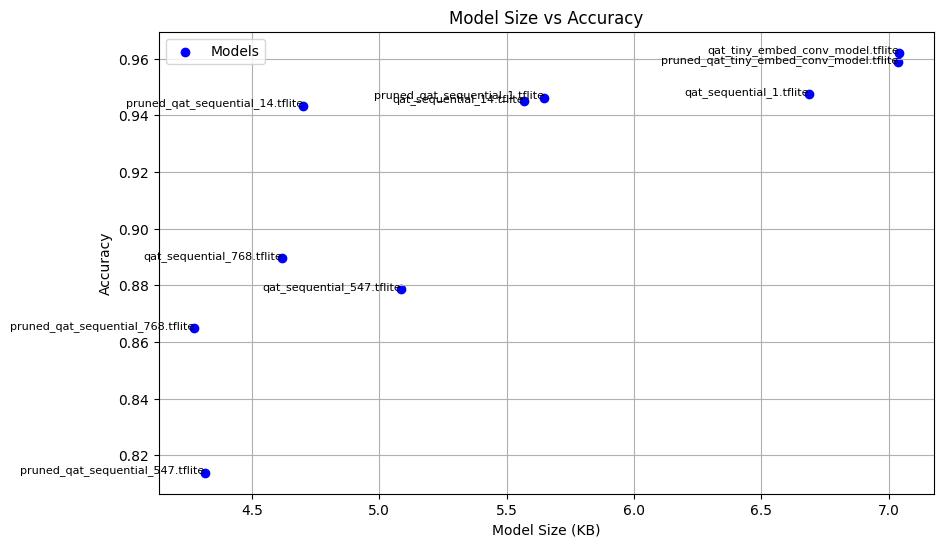

In [40]:
# Final visualization for pqat and qat models in tflite format
p_and_qat_size_and_acc

# Extract keys, sizes, and accuracies from the dictionary
keys = list(p_and_qat_size_and_acc.keys())
sizes = [value[0] for value in p_and_qat_size_and_acc.values()]
accuracies = [value[1] for value in p_and_qat_size_and_acc.values()]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(sizes, accuracies, color='blue', label='Models')

# Annotate each point with its corresponding model name
for i, key in enumerate(keys):
    plt.text(sizes[i], accuracies[i], key, fontsize=8, ha='right')

# Add labels, title, and grid
plt.xlabel('Model Size (KB)')
plt.ylabel('Accuracy')
plt.title('Model Size vs Accuracy')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

## Post training quantization

https://ai.google.dev/edge/litert/models/post_training_quant

In [41]:
# Function to quantize the models using TensorFlow Lite Micro with different granularities
def quantize_model(model, optimization_strategy):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    if optimization_strategy == 'weight':
        # Quantize only weights
        converter.target_spec.supported_types = [tf.float16]
    elif optimization_strategy == 'full':
        # Full integer quantization
        def representative_dataset():
            for spectrogram, _ in train_spectrogram_ds.take(1000):
                yield [spectrogram]
        converter.representative_dataset = representative_dataset
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.uint8
        converter.inference_output_type = tf.uint8
    elif optimization_strategy == 'dynamic':
        # Dynamic range quantization
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
    else:
        raise ValueError("Unsupported optimization strategy. Use 'weight', 'full', or 'dynamic'.")
    tflite_model = converter.convert()
    return tflite_model

In [42]:
# Function to quantize the models using post-training integer quantization with int16 activations and int8 weights
def quantize_model_int16x8(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    def representative_dataset():
        for spectrogram, _ in train_spectrogram_ds.take(100):
            yield [spectrogram]
    converter.representative_dataset = representative_dataset
    converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8]
    converter.inference_input_type = tf.int16
    converter.inference_output_type = tf.int16
    tflite_model = converter.convert()
    return tflite_model

In [43]:
for model in basic_pruned_models:
    print("Model name:", model.name)

Model name: sequential_547
Model name: sequential_768
Model name: sequential_14
Model name: sequential_1
Model name: tiny_embed_conv_model


In [44]:
# Quantize each trained model with different granularities and save them
quantization_strategies = ['weight', 'full', 'dynamic']

for i, model in enumerate(basic_pruned_models):
    for strategy in quantization_strategies:
        print(f'Quantizing Model {model.name} with {strategy} strategy')
        tflite_model = quantize_model(model, strategy)
        model_filename = f'{model.name}_{strategy}_quantized.tflite'
        with open(model_filename, 'wb') as f:
            f.write(tflite_model)
        print(f'Model {i} quantized with {strategy} strategy and saved as {model_filename}')

    # Quantize using post-training integer quantization with int16 activations and int8 weights
    print(f'Quantizing Model {i} with int16 activations and int8 weights')
    tflite_model_int16x8 = quantize_model_int16x8(model)
    model_filename_int16x8 = f'model_{i}_int16x8_quantized.tflite'
    with open(model_filename_int16x8, 'wb') as f:
        f.write(tflite_model_int16x8)
    print(f'Model {i} quantized with int16 activations and int8 weights and saved as {model_filename_int16x8}')

Quantizing Model sequential_547 with weight strategy


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpr8texwz4/assets


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpr8texwz4/assets


Model 0 quantized with weight strategy and saved as sequential_547_weight_quantized.tflite
Quantizing Model sequential_547 with full strategy


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpwgsx84_p/assets


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpwgsx84_p/assets
/share/pkg.7/tensorflow/2.11.0/install/lib/SCC/../python3.10/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


Model 0 quantized with full strategy and saved as sequential_547_full_quantized.tflite
Quantizing Model sequential_547 with dynamic strategy


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmp1fpm3l4r/assets


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmp1fpm3l4r/assets


Model 0 quantized with dynamic strategy and saved as sequential_547_dynamic_quantized.tflite
Quantizing Model 0 with int16 activations and int8 weights
INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpuvdwer6_/assets


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpuvdwer6_/assets


Model 0 quantized with int16 activations and int8 weights and saved as model_0_int16x8_quantized.tflite
Quantizing Model sequential_768 with weight strategy


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmp0spch_27/assets


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmp0spch_27/assets


Model 1 quantized with weight strategy and saved as sequential_768_weight_quantized.tflite
Quantizing Model sequential_768 with full strategy


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmppqcpcd3l/assets


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmppqcpcd3l/assets
/share/pkg.7/tensorflow/2.11.0/install/lib/SCC/../python3.10/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


Model 1 quantized with full strategy and saved as sequential_768_full_quantized.tflite
Quantizing Model sequential_768 with dynamic strategy


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpj30o6w8d/assets


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpj30o6w8d/assets


Model 1 quantized with dynamic strategy and saved as sequential_768_dynamic_quantized.tflite
Quantizing Model 1 with int16 activations and int8 weights


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpss3zhlrs/assets


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpss3zhlrs/assets


Model 1 quantized with int16 activations and int8 weights and saved as model_1_int16x8_quantized.tflite
Quantizing Model sequential_14 with weight strategy


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpbah72ij_/assets


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpbah72ij_/assets


Model 2 quantized with weight strategy and saved as sequential_14_weight_quantized.tflite
Quantizing Model sequential_14 with full strategy
INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmp7pl7rojm/assets


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmp7pl7rojm/assets
/share/pkg.7/tensorflow/2.11.0/install/lib/SCC/../python3.10/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


Model 2 quantized with full strategy and saved as sequential_14_full_quantized.tflite
Quantizing Model sequential_14 with dynamic strategy


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpxp_u31ol/assets


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpxp_u31ol/assets


Model 2 quantized with dynamic strategy and saved as sequential_14_dynamic_quantized.tflite
Quantizing Model 2 with int16 activations and int8 weights


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpiv_sw88s/assets


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpiv_sw88s/assets


Model 2 quantized with int16 activations and int8 weights and saved as model_2_int16x8_quantized.tflite
Quantizing Model sequential_1 with weight strategy


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmp_l3wfaxu/assets


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmp_l3wfaxu/assets


Model 3 quantized with weight strategy and saved as sequential_1_weight_quantized.tflite
Quantizing Model sequential_1 with full strategy


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpp890k6ry/assets


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpp890k6ry/assets
/share/pkg.7/tensorflow/2.11.0/install/lib/SCC/../python3.10/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


Model 3 quantized with full strategy and saved as sequential_1_full_quantized.tflite
Quantizing Model sequential_1 with dynamic strategy


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmphzbxnvuk/assets


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmphzbxnvuk/assets


Model 3 quantized with dynamic strategy and saved as sequential_1_dynamic_quantized.tflite
Quantizing Model 3 with int16 activations and int8 weights


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpguw1wmjm/assets


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpguw1wmjm/assets


Model 3 quantized with int16 activations and int8 weights and saved as model_3_int16x8_quantized.tflite
Quantizing Model tiny_embed_conv_model with weight strategy


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpymvy4cmg/assets


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpymvy4cmg/assets


Model 4 quantized with weight strategy and saved as tiny_embed_conv_model_weight_quantized.tflite
Quantizing Model tiny_embed_conv_model with full strategy


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpbdq6v4wi/assets


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpbdq6v4wi/assets
/share/pkg.7/tensorflow/2.11.0/install/lib/SCC/../python3.10/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


Model 4 quantized with full strategy and saved as tiny_embed_conv_model_full_quantized.tflite
Quantizing Model tiny_embed_conv_model with dynamic strategy


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpmr9ppsr_/assets


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmpmr9ppsr_/assets


Model 4 quantized with dynamic strategy and saved as tiny_embed_conv_model_dynamic_quantized.tflite
Quantizing Model 4 with int16 activations and int8 weights


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmptu0_uwnv/assets


INFO:tensorflow:Assets written to: /scratch/1365637.1.l40s/tmptu0_uwnv/assets


Model 4 quantized with int16 activations and int8 weights and saved as model_4_int16x8_quantized.tflite


## Quantized Model Evaluation

In [45]:
def evaluate_quantized_model(tflite_model_path):
    # Load the TFLite model and allocate tensors
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Determine the expected input shape and type
    input_dtype = input_details[0]['dtype']
    input_shape = input_details[0]['shape'][1:3]  # Extract height and width

    # Evaluate the model on the test dataset
    total_correct = 0
    total_samples = 0

    for spectrogram_batch, label_batch in test_spectrogram_ds:
        for spectrogram, label in zip(spectrogram_batch, label_batch):
            # Resize the spectrogram to the expected input shape
            resized_spectrogram = tf.image.resize(spectrogram, input_shape).numpy()

            # Set the tensor with resized spectrogram
            interpreter.set_tensor(input_details[0]['index'], np.expand_dims(resized_spectrogram, axis=0).astype(input_dtype))
            interpreter.invoke()

            # Get the model's predictions
            output_data = interpreter.get_tensor(output_details[0]['index'])
            predicted_label = np.argmax(output_data)

            # Update the accuracy metrics
            total_correct += (predicted_label == label.numpy())
            total_samples += 1

    # Compute accuracy
    accuracy = total_correct / total_samples
    return accuracy


In [46]:
# Evaluate each quantized model
for model_filename in os.listdir('.'):
    if model_filename.endswith('_quantized.tflite'):
        print(f'Evaluating Model: {model_filename}')
        accuracy = evaluate_quantized_model(model_filename)
        print(f'Model {model_filename} quantization accuracy: {accuracy:.4f}')



Evaluating Model: sequential_547_full_quantized.tflite
Model sequential_547_full_quantized.tflite quantization accuracy: 0.5563
Evaluating Model: model_2_int16x8_quantized.tflite
Model model_2_int16x8_quantized.tflite quantization accuracy: 0.5563
Evaluating Model: sequential_14_weight_quantized.tflite
Model sequential_14_weight_quantized.tflite quantization accuracy: 0.9380
Evaluating Model: sequential_1_dynamic_quantized.tflite
Model sequential_1_dynamic_quantized.tflite quantization accuracy: 0.9433
Evaluating Model: model_4_int16x8_quantized.tflite
Model model_4_int16x8_quantized.tflite quantization accuracy: 0.5563
Evaluating Model: tiny_embed_conv_model_dynamic_quantized.tflite
Model tiny_embed_conv_model_dynamic_quantized.tflite quantization accuracy: 0.9490
Evaluating Model: sequential_768_dynamic_quantized.tflite
Model sequential_768_dynamic_quantized.tflite quantization accuracy: 0.2622
Evaluating Model: model_3_int16x8_quantized.tflite
Model model_3_int16x8_quantized.tflite 

In [47]:
# Function to print the size and memory requirements of the quantized models
def print_quantized_model_sizes(model_filenames):
    sizes = []
    for model_filename in model_filenames:
        if os.path.exists(model_filename):
            model_size = get_gzipped_model_size(model_filename)
            #model_size = os.path.getsize(model_filename) / 1000  # Size in KB
            sizes.append((model_filename, model_size))
            print(f'Model: {model_filename} Size: {model_size:.2f} KB')
        else:
            print(f'Model: {model_filename} not found.')
    return sizes


Quantized Model Sizes:
Model: sequential_547_full_quantized.tflite Size: 4.13 KB
Model: model_2_int16x8_quantized.tflite Size: 4.69 KB
Model: sequential_14_weight_quantized.tflite Size: 6.66 KB
Model: sequential_1_dynamic_quantized.tflite Size: 5.30 KB
Model: model_4_int16x8_quantized.tflite Size: 5.91 KB
Model: tiny_embed_conv_model_dynamic_quantized.tflite Size: 7.06 KB
Model: sequential_768_dynamic_quantized.tflite Size: 4.97 KB
Model: model_3_int16x8_quantized.tflite Size: 5.70 KB
Model: sequential_547_weight_quantized.tflite Size: 6.21 KB
Model: sequential_14_dynamic_quantized.tflite Size: 4.66 KB
Model: sequential_768_full_quantized.tflite Size: 4.16 KB
Model: sequential_1_weight_quantized.tflite Size: 8.23 KB
Model: sequential_1_full_quantized.tflite Size: 5.48 KB
Model: sequential_547_dynamic_quantized.tflite Size: 4.27 KB
Model: model_1_int16x8_quantized.tflite Size: 4.29 KB
Model: model_0_int16x8_quantized.tflite Size: 4.22 KB
Model: sequential_14_full_quantized.tflite Size:

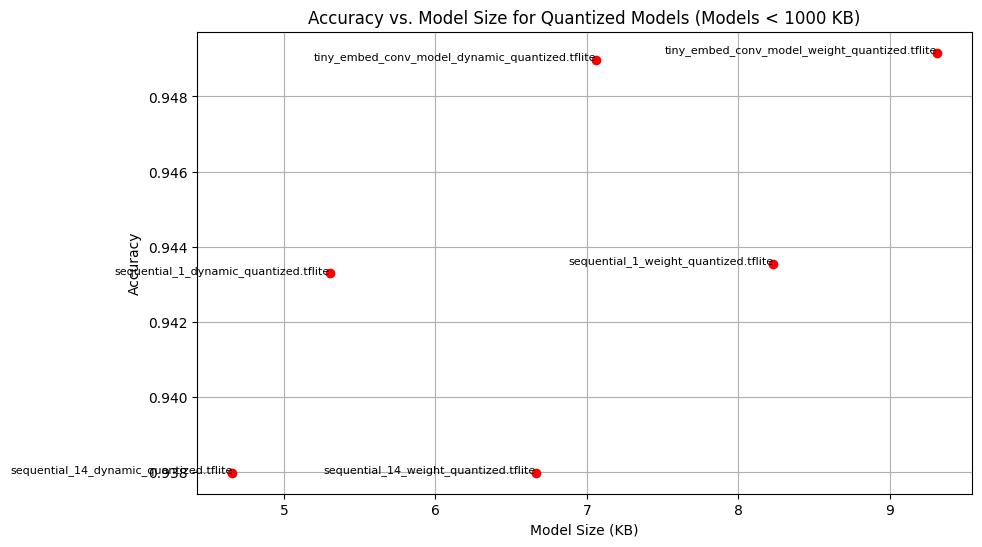

In [48]:
# List of quantized model filenames
quantized_model_filenames = []
#for i in range(0, len(basic_pruned_models)):
#    for strategy in ['weight', 'full', 'dynamic']:
#        quantized_model_filenames.append(f'model_{i}_{strategy}_quantized.tflite')
#    quantized_model_filenames.append(f'model_{i}_int16x8_quantized.tflite')


for model_filename in os.listdir('.'):
    if model_filename.endswith('_quantized.tflite'):
        quantized_model_filenames.append(model_filename)
        
# Print sizes of quantized models and store the sizes
print("\nQuantized Model Sizes:")
quantized_model_sizes = print_quantized_model_sizes(quantized_model_filenames)

# Evaluate each quantized model and collect accuracies
quantized_accuracies = []

for model_filename, model_size in quantized_model_sizes:
    print(f'Evaluating {model_filename}')
    accuracy = evaluate_quantized_model(model_filename)
    quantized_accuracies.append((model_filename, model_size, accuracy))
    
#print(quantized_accuracies)

# Filter accuracies for models smaller than 1000 KB and accuracy greater than 0.8
filtered_accuracies = [tup for tup in quantized_accuracies if tup[2] > 0.6 and tup[1] < 40]

# Plot accuracy vs. model size for quantized models
model_names, model_sizes, accuracies = zip(*filtered_accuracies)

plt.figure(figsize=(10, 6))

# Plot points without connecting lines by setting linestyle='None'
plt.plot(model_sizes, accuracies, marker='o', linestyle='None', color='r')

# Annotate each point with the model name
for i, model_name in enumerate(model_names):
    plt.text(model_sizes[i], accuracies[i], model_name, fontsize=8, ha='right')

plt.xlabel('Model Size (KB)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Model Size for Quantized Models (Models < 1000 KB)')
plt.grid(True)
plt.show()


In [49]:
def evaluate_tflite_model(tflite_model_path, test_data, test_labels):
    # Load the TFLite model and allocate tensors
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    
    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Determine input data type and shape
    input_dtype = input_details[0]['dtype']
    input_shape = input_details[0]['shape'][1:3]  # [height, width]
    
    # Run inference on the test data
    correct_predictions = 0
    for i, test_sample in enumerate(test_data):
        # Resize spectrogram to match model's expected input shape
        resized_sample = tf.image.resize(test_sample, input_shape).numpy()
        
        # Prepare input data, converting to expected dtype if necessary
        input_data = np.expand_dims(resized_sample, axis=0)
        if input_dtype == np.uint8:
            input_data = (input_data * 255).astype(np.uint8)  # Scale to UINT8
        else:
            input_data = input_data.astype(input_dtype)

        interpreter.set_tensor(input_details[0]['index'], input_data)
        
        # Run inference
        interpreter.invoke()
        
        # Get the output and check the prediction
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predicted_label = np.argmax(output_data)
        true_label = test_labels[i]
        
        if predicted_label == true_label:
            correct_predictions += 1

    # Calculate accuracy
    accuracy = correct_predictions / len(test_data)
    return accuracy



def plot_tflite_size_vs_accuracy(folder_path, test_spectrogram_ds): 
    test_data, test_labels = ds_to_numpy(test_spectrogram_ds)
    # Lists to store results
    model_sizes = []
    accuracies = []
    model_names = []
    
    # Iterate through all TFLite files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".tflite"):
            model_path = os.path.join(folder_path, filename)
            model_name = os.path.splitext(filename)[0]
            
            # Get model size in KB
            model_size = get_gzipped_model_size(model_path)
            #model_size = os.path.getsize(model_path) / 1024  # Convert bytes to KB
            
            # Evaluate the TFLite model accuracy
            accuracy = evaluate_tflite_model(model_path, test_data, test_labels)
            
            # Store results
            model_sizes.append(model_size)
            accuracies.append(accuracy)
            model_names.append(model_name)
            
            # Print the details
            print(f"Model: {model_name}, Size: {model_size:.2f} KB, Accuracy: {accuracy:.4f}")
    
    # Plotting accuracy vs. model size
    plt.figure(figsize=(10, 6))
    plt.plot(model_sizes, accuracies, marker='o', linestyle='', color='b')

    # Annotate each point with the model name
    for i, model_name in enumerate(model_names):
        plt.text(model_sizes[i], accuracies[i], model_name, fontsize=9, ha='right')

    # Add labels and title
    plt.xlabel('Model Size (KB)')
    plt.ylabel('Test Accuracy')
    plt.title('TFLite Model Accuracy vs. Model Size')
    plt.grid(True)
    plt.show()

    return model_sizes, accuracies, model_names


Model: pruned_qat_tiny_embed_conv_model, Size: 7.04 KB, Accuracy: 0.9588
Model: qat_sequential_1, Size: 6.69 KB, Accuracy: 0.9475
Model: sequential_547_full_quantized, Size: 4.13 KB, Accuracy: 0.1909
Model: model_2_int16x8_quantized, Size: 4.69 KB, Accuracy: 0.5563
Model: sequential_14_weight_quantized, Size: 6.66 KB, Accuracy: 0.9380
Model: sequential_1_dynamic_quantized, Size: 5.30 KB, Accuracy: 0.9433
Model: model_4_int16x8_quantized, Size: 5.91 KB, Accuracy: 0.5563
Model: tiny_embed_conv_model_dynamic_quantized, Size: 7.06 KB, Accuracy: 0.9490
Model: sequential_768_dynamic_quantized, Size: 4.97 KB, Accuracy: 0.2622
Model: model_3_int16x8_quantized, Size: 5.70 KB, Accuracy: 0.5563
Model: pruned_qat_sequential_547, Size: 4.31 KB, Accuracy: 0.8139
Model: sequential_547_weight_quantized, Size: 6.21 KB, Accuracy: 0.1901
Model: sequential_14_dynamic_quantized, Size: 4.66 KB, Accuracy: 0.9380
Model: sequential_768_full_quantized, Size: 4.16 KB, Accuracy: 0.2717
Model: pruned_qat_sequentia

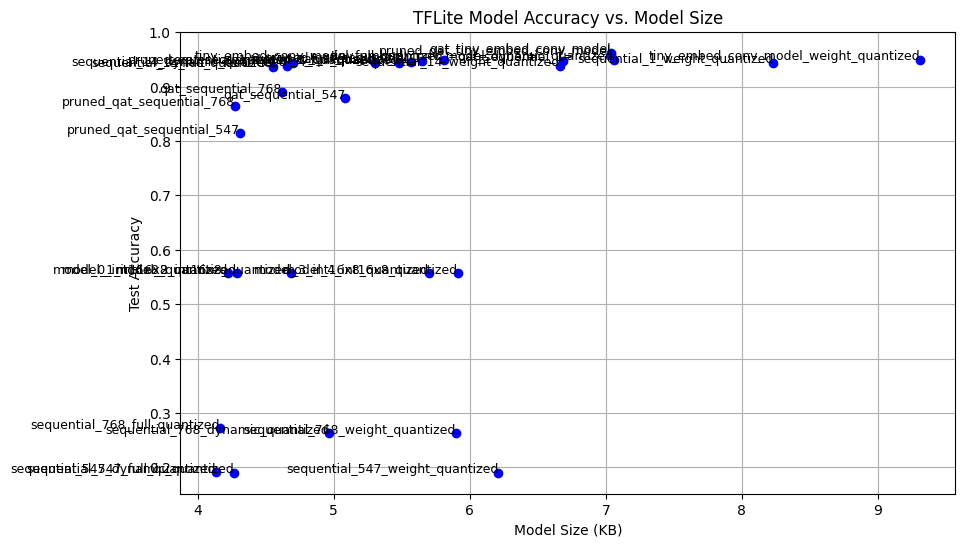

In [50]:
model_sizes, accuracies, model_names = [], [], []
#folder_path = "C:\\Users\\adamk\\Downloads\\micro_speech_model_making\\notebooks\\"
# for scc
folder_path = "."
model_sizes, accuracies, model_names = plot_tflite_size_vs_accuracy(folder_path, test_spectrogram_ds)
# C:\Users\adamk\Downloads\micro_speech_model_making\notebooks\val_spec_ds.tfrecord

In [51]:
def plot_filtered_model_size_vs_accuracy(model_sizes, accuracies, model_names, max_size, min_accuracy):
    # Filter models based on the provided criteria
    filtered_sizes = [size for size, acc in zip(model_sizes, accuracies) if size < max_size and acc > min_accuracy]
    filtered_accuracies = [acc for size, acc in zip(model_sizes, accuracies) if size < max_size and acc > min_accuracy]
    filtered_names = [name for size, acc, name in zip(model_sizes, accuracies, model_names) if size < max_size and acc > min_accuracy]

    # Print details of filtered models
    for size, acc, name in zip(filtered_sizes, filtered_accuracies, filtered_names):
        print(f"Name: {name}, Size: {size:.2f} KB, Accuracy: {acc:.4f}")

    # Plot only the filtered models
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_sizes, filtered_accuracies, marker='o', linestyle='', color='b', label=f"Size < {max_size} KB & Accuracy > {min_accuracy*100}%")
    
    # Annotate each filtered point with the model name
    for i, model_name in enumerate(filtered_names):
        plt.text(filtered_sizes[i], filtered_accuracies[i], model_name, fontsize=9, ha='right')

    # Add labels and title
    plt.xlabel('Model Size (KB)')
    plt.ylabel('Test Accuracy')
    plt.title(f'TFLite Model Accuracy vs. Model Size (Filtered by Size < {max_size} KB & Accuracy > {min_accuracy*100}%)')
    plt.legend()
    plt.grid(True)
    plt.show()




Name: pruned_qat_tiny_embed_conv_model, Size: 7.04 KB, Accuracy: 0.9588
Name: qat_sequential_1, Size: 6.69 KB, Accuracy: 0.9475
Name: sequential_14_weight_quantized, Size: 6.66 KB, Accuracy: 0.9380
Name: sequential_1_dynamic_quantized, Size: 5.30 KB, Accuracy: 0.9433
Name: tiny_embed_conv_model_dynamic_quantized, Size: 7.06 KB, Accuracy: 0.9490
Name: sequential_14_dynamic_quantized, Size: 4.66 KB, Accuracy: 0.9380
Name: pruned_qat_sequential_14, Size: 4.70 KB, Accuracy: 0.9434
Name: pruned_qat_sequential_1, Size: 5.65 KB, Accuracy: 0.9462
Name: sequential_1_full_quantized, Size: 5.48 KB, Accuracy: 0.9424
Name: qat_sequential_14, Size: 5.57 KB, Accuracy: 0.9450
Name: sequential_14_full_quantized, Size: 4.55 KB, Accuracy: 0.9365
Name: tiny_embed_conv_model_full_quantized, Size: 5.81 KB, Accuracy: 0.9493
Name: qat_tiny_embed_conv_model, Size: 7.04 KB, Accuracy: 0.9621


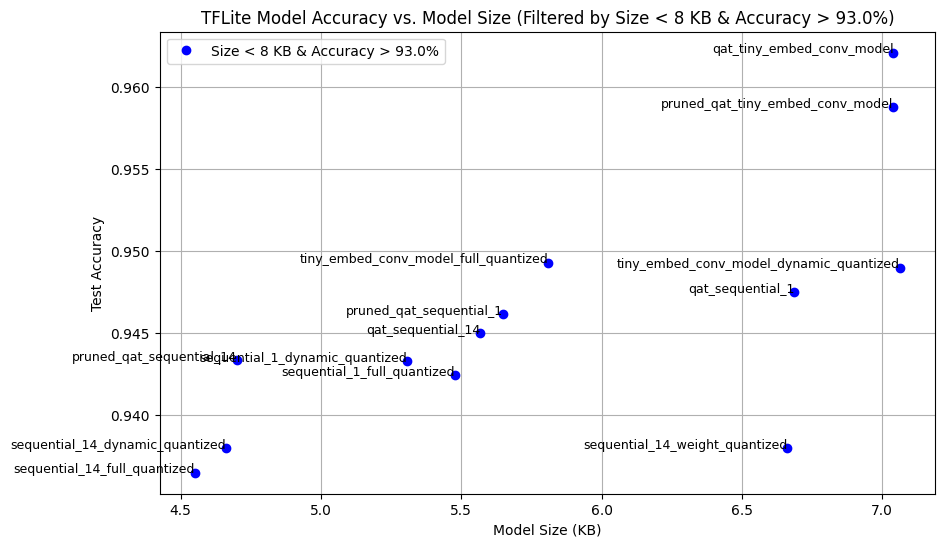

In [54]:
plot_filtered_model_size_vs_accuracy(model_sizes, accuracies, model_names, max_size=8, min_accuracy=0.93)